In [2]:
import importlib

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import logomaker as lm

import tensorflow as tf

from Modules import utils, tf_utils
from Modules.tf_utils import mae_cor, correlate, get_profile
import kMC_sequence_design
from kMC_sequence_design import get_profile_hint, rmse, GC_energy, get_profile_chunk

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

2023-10-20 14:20:54.882102: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [19]:
importlib.reload(utils)
importlib.reload(tf_utils)
importlib.reload(kMC_sequence_design)

<module 'kMC_sequence_design' from '/home/alex/mnhn-internship_DeepCNN_ChIP-seq/kMC_sequence_design.py'>

Models

In [31]:
model_pol_name = 'model_myco_pol_17'
# with tf.distribute.MirroredStrategy().scope():
model_pol = tf.keras.models.load_model(f'/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_pol_name}/model',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_nuc_name = 'model_myco_nuc_2'
model_nuc = tf.keras.models.load_model(f'/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_nuc_name}/model',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_coh_name = 'model_myco_coh_14'
model_coh = tf.keras.models.load_model(f'/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_coh_name}/model',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_rna_name = 'weight_CNN_RNA_seq_2001_12_8_4_SRR7131299' # order 'ATGC'
model_rna = tf.keras.models.load_model(f'/home/alex/shared_folder/JB_seqdes/{model_rna_name}.hdf5',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_rna.input_shape

2023-10-20 15:05:12.211258: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-10-20 15:05:12.266599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-20 15:05:12.266752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-10-20 15:05:12.266799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-20 15:05:12.266914: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID

(None, 2001, 4, 1)

In [12]:
with np.load('/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.npz') as f:
    one_hot_yeast = {k: f[k] for k in f.keys() if k[:3] == 'chr'}
print(list(one_hot_yeast.keys()))

['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX', 'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI']


# kinetic Monte-Carlo

Flanking regions file

In [ ]:
# flanks = {'left': [], 'right': [], 'pos': []}
# for k, v in one_hot_yeast.items():
#     pos = np.random.randint(1000, len(v)-1000)
#     window = v[pos - 1000:pos+1000]
#     assert len(window) == 2000
#     assert window.sum() == 2000
#     window = np.argmax(window, axis=-1)
#     flanks['left'].append(window[:1000])
#     flanks['right'].append(window[1000:])
#     flanks['pos'].append(pos)
# for k, v in flanks.items():
#     flanks[k] = np.array(v)
# np.savez('/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco_random1kbflanks_ACGTidx.npz', **flanks)

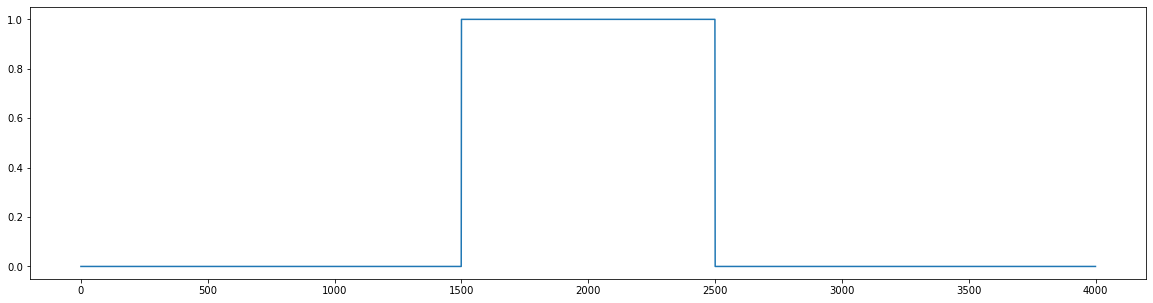

In [9]:
length = 4000
midlen = 1000
sidelen = (length - midlen) // 2
target = np.array([0]*sidelen + [1]*midlen + [0]*sidelen)
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(target)
# np.savez('/home/alex/shared_folder/SCerevisiae/generated/targets/4kb_midpeak1kb.npz', forward=target, reverse=target)
# np.savez('/home/alex/shared_folder/SCerevisiae/generated/targets/4kb_midpeak200b.npz', forward=target, reverse=target)

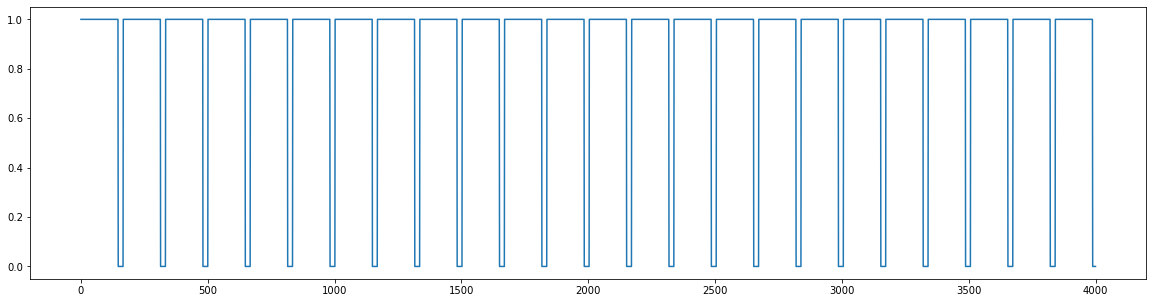

In [43]:
length = 4000
tile = np.array([1]*147 + [0]*20)
target = np.tile(tile, length // len(tile) + 1)[:length]
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(target)
# np.savez('/home/alex/shared_folder/SCerevisiae/generated/targets/4kb_sharpnuc147_linker20.npz', forward=target, reverse=target)

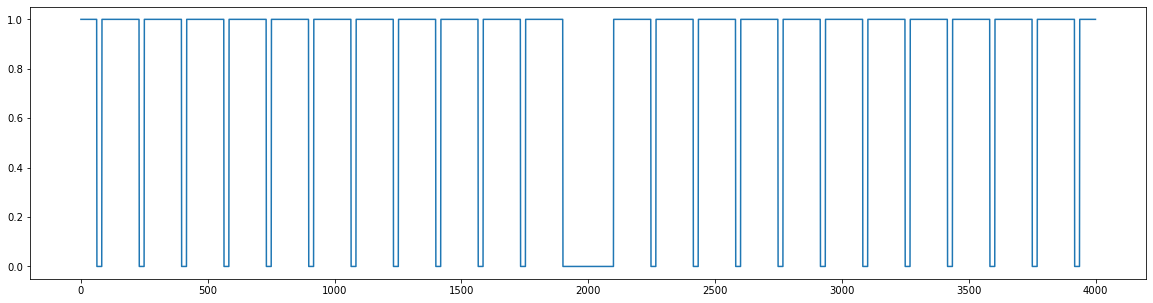

In [6]:
length = 4000
midlen = 200
tile = np.array([1]*147 + [0]*20)
regnucs = np.tile(tile, length // (2*len(tile)) + 1)[:length // 2 - midlen // 2]
target = np.concatenate([np.flip(regnucs), [0]*midlen, regnucs])
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(target)
# np.savez('/home/alex/shared_folder/SCerevisiae/generated/targets/4kb_sharpnuc147_linker20_middepleted1kb.npz', forward=target, reverse=target)
# np.savez('/home/alex/shared_folder/SCerevisiae/generated/targets/4kb_sharpnuc147_linker20_middepleted200b.npz', forward=target, reverse=target)

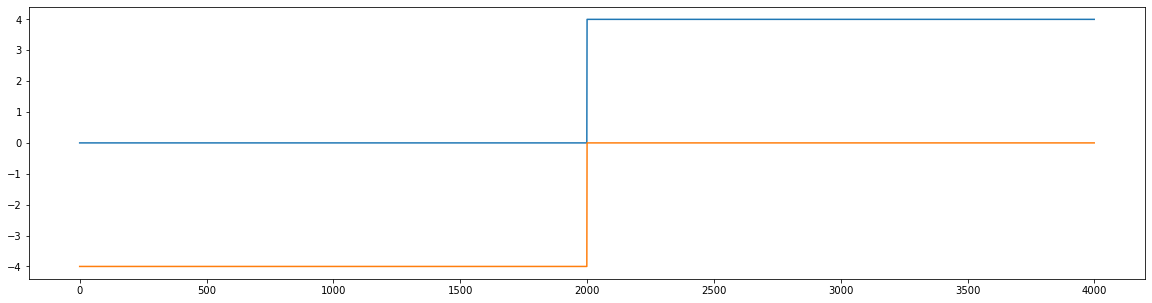

In [53]:
target = np.array([0]*2000 + [4]*2000)
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(target)
ax.plot(-(4 - target))
# np.savez('/home/alex/shared_folder/SCerevisiae/generated/targets/4kb_peakrevthenfor_val4.npz', forward=target, reverse=4-target)

Analysing experiments

In [32]:
def energy_parser(file):
    energies = np.loadtxt(file)
    with open(file, 'r') as f:
        n_seqs = 0
        for line in f:
            if n_seqs != 0 and line.startswith('#'):
                break
            if not line.startswith('#'):
                n_seqs += 1
    return np.transpose(energies.reshape(-1, n_seqs, energies.shape[1]), [1, 0, 2])

Energy

(2, 10, 5)


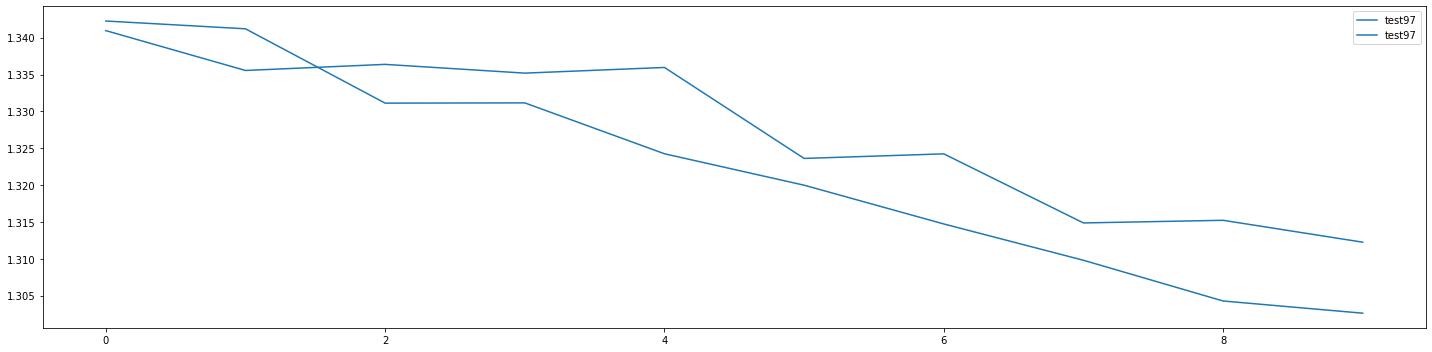

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')#, sharey=True)
temps = ['2e-4', '1e-4', '5e-5']
exp_ids = [f'test{n}' for n in range(97, 98)] # [f'lowpol_4kb_temp{t}' for t in temps] + [f'highpol_4kb_temp{t}_mid' for t in temps] #
exp_labels = exp_ids #
for exp_id, exp_lab, color in zip(exp_ids, exp_labels, colors):
    # if int(exp_id[4:]) in [94, 95]:
    #     continue
    energies = energy_parser(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_id}/energy.txt')
    print(energies.shape)
    ax.plot(energies[:2, :, 0].T, label=exp_lab, color=color)
ax.legend()
# ax.set_xlim(0, 100)
# ax.set_ylim((-0.001, 2))

(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)


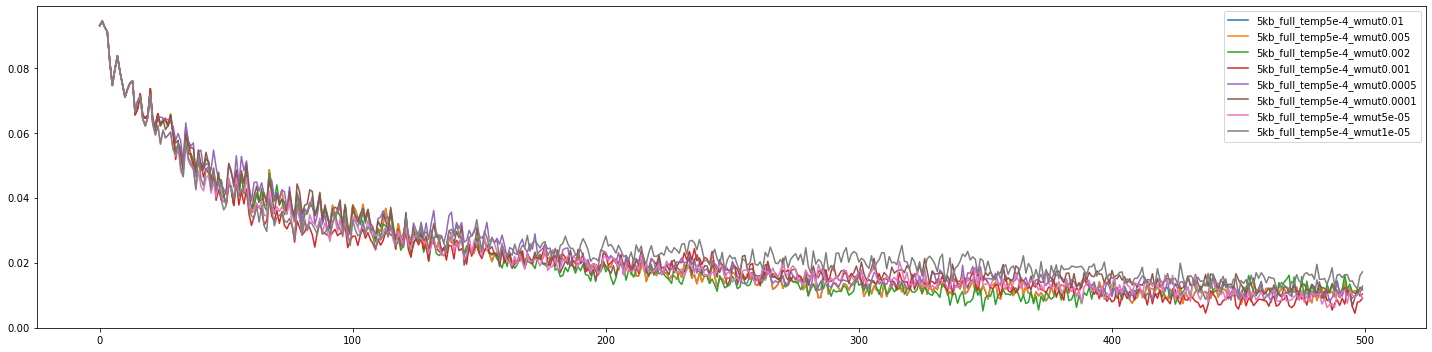

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')#, sharey=True)
exp_ids = [f'test{n}' for n in range(49, 57)]
wmuts = [0.01, 0.005, 0.002, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
exp_labels = [f'5kb_full_temp5e-4_wmut{w}' for w in wmuts]
for exp_id, exp_lab, color in zip(exp_ids, exp_labels, colors):
    energies = energy_parser(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_id}/energy.txt')
    print(energies.shape)
    ax.plot(energies[:1, :, 0].T, label=exp_lab, color=color)
ax.legend()

Probabilities

(2, 12000)


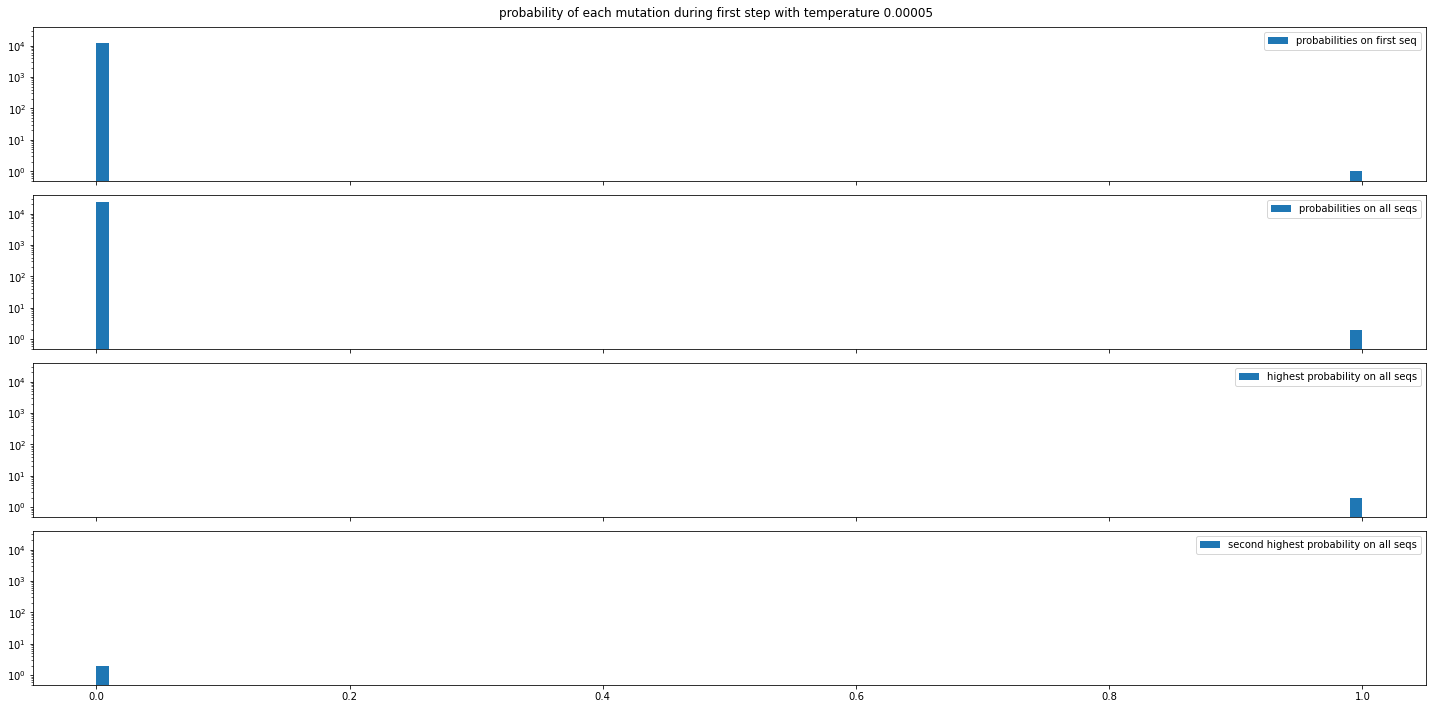

In [46]:
exp_name = 'test97'
step = 0
probs = np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/probs/prob_step{step}.npy')
print(probs.shape)
probs = np.sort(probs, axis=1)
fig, axes = plt.subplots(4, 1, figsize=(20, 10), facecolor='w', layout='tight', sharey=True, sharex=True)
fig.suptitle('probability of each mutation during first step with temperature 0.00005')
axes[0].hist(probs[0], bins=100, range=(0, 1), label='probabilities on first seq')
axes[1].hist(probs.ravel(), bins=100, range=(0, 1), label='probabilities on all seqs')
axes[2].hist(probs[:, -1], bins=100, range=(0, 1), label='highest probability on all seqs')
axes[3].hist(probs[:, -2], bins=100, range=(0, 1), label='second highest probability on all seqs')
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(bottom=5e-1)
    ax.legend()
plt.show()

In [47]:
# exp_name = 'lowpol_4kb_temp1e-4'
energies = energy_parser(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/energy.txt')
probs = []
for step in range(energies.shape[1]):
    probs.append(np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/probs/prob_step{step}.npy'))
probs = np.stack(probs, axis=1)
print(probs.shape)
probs = np.sort(probs, axis=-1)

(2, 10, 12000)


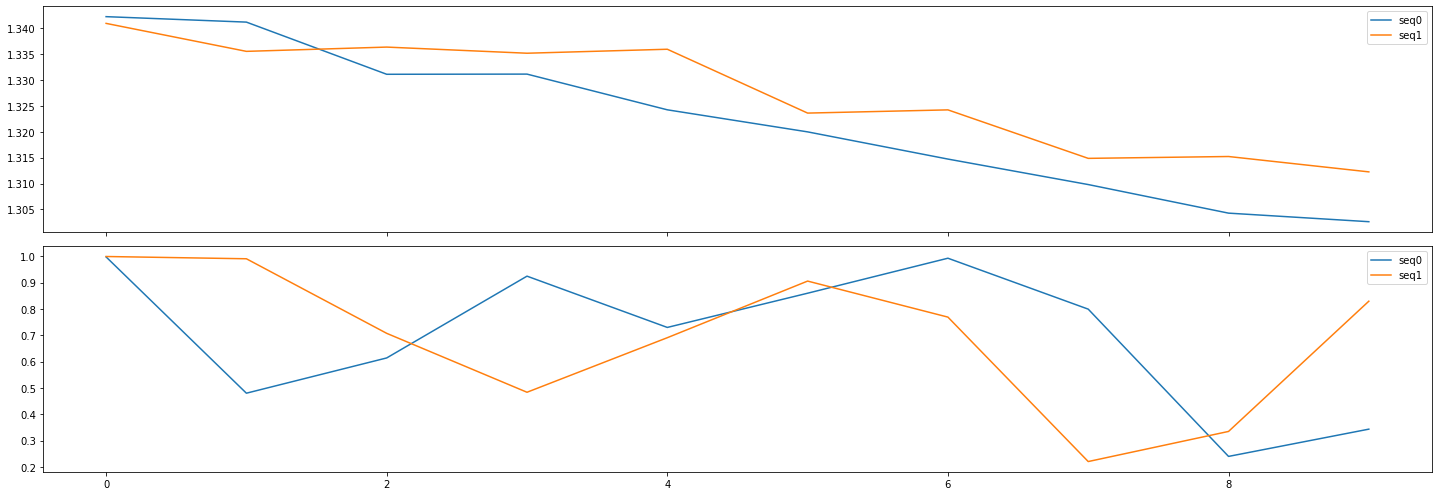

In [48]:
start = 0
stop = 2
fig, axes = plt.subplots(2, 1, figsize=(20, 7), facecolor='w', layout='tight', sharex=True)
axes[0].plot(energies[start:stop, :, 0].T, label=[f'seq{i}' for i in range(start, stop)])
axes[1].plot(probs[start:stop, :, -1].T, label=[f'seq{i}' for i in range(start, stop)])
for ax in axes:
    ax.legend()
plt.show()

Designed sequences

In [41]:
exp_name = 'test96'
seqs = [np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/start_seqs.npy')]
step = 0
while True:
    try:
        seqs.append(np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/mut_seqs_step{step}.npy'))
        step += 1
    except FileNotFoundError:
        break
seqs = np.stack(seqs, axis=1)
print(seqs.shape)

(2, 11, 4000)


[1236 1415 1424 1893 1988 2574 2790 2818 2881 3163]


<BarContainer object of 10 artists>

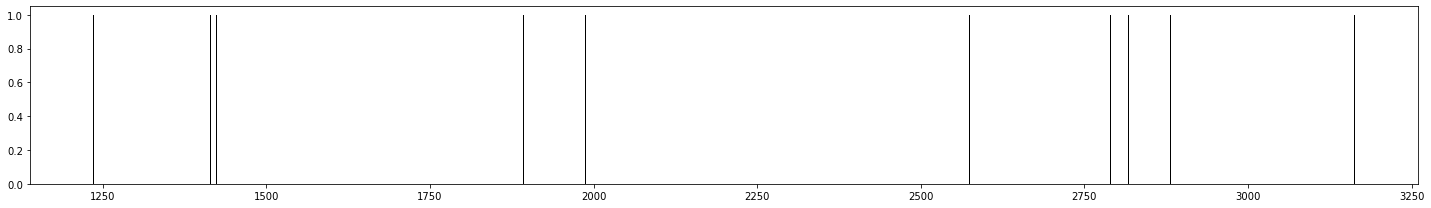

In [42]:
seq_idx = 0
print(np.where(seqs[seq_idx, 0] != seqs[seq_idx, -1])[0])
fig, ax = plt.subplots(1, 1, figsize=(20, 3), facecolor='w', layout='tight')
ax.bar(np.where(seqs[seq_idx, 0] != seqs[seq_idx, -1])[0], height=1, width=1.3, color='k')
# ax.set_xlim(0, seqs.shape[-1])

In [ ]:
# start_seqs = np.load(f'/home/alex/shared_folder/SCerevisiae/generated/test9/start_seqs.npy')
# np.save('/home/alex/shared_folder/SCerevisiae/generated/test9/start_seqs_first1.npy', start_seqs[:1])

In [13]:
with np.load('/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco_random1kbflanks_ACGTidx.npz') as f:
    flank_left = f['left']
    flank_right = f['right']

Repredicting

In [43]:
with np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/target.npz') as f:
    target = f['forward']
    target_rev = f['reverse']

In [44]:
# preds, indices = get_profile_chunk(seqs, model_rna, 2048, head_interval=128, middle=False, return_index=True)
# preds_rev, indices_rev = get_profile_chunk(seqs, model_pol, 2048, head_interval=128, middle=False, return_index=True, reverse=True)
preds, indices = get_profile_chunk(seqs, model_nuc, 2001, return_index=True)
preds_rev, indices_rev = get_profile_chunk(seqs, model_nuc, 2001, return_index=True, reverse=True)
# preds = get_profile_mid1(seqs, model_rna, 2001, one_hot_converter=lambda x: np_idx_to_one_hot(x, order='ATGC', extradims=-1), return_index=True)
# preds_rev = get_profile_mid1(seqs, model_rna, 2001, one_hot_converter=lambda x: np_idx_to_one_hot(x, order='ATGC', extradims=-1), return_index=True, reverse=True)
loss = rmse(target[indices], preds)
loss_rev = rmse(target[indices_rev], preds_rev)
gc_energy = GC_energy(seqs, 0.3834)

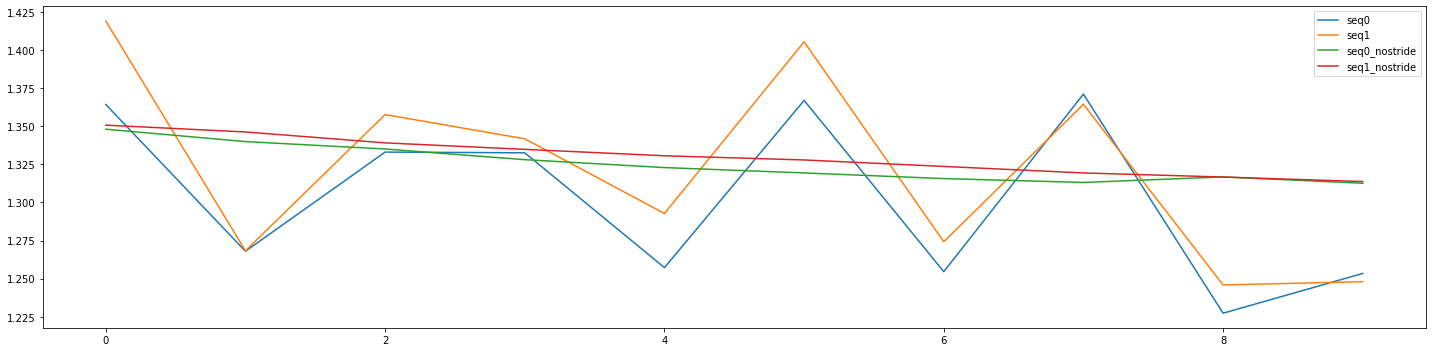

In [45]:
energies = energy_parser(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/energy.txt')
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')
ax.plot(energies[:2, :, 0].T, label=[f'seq{i}' for i in range(2)])
for idx in range(len(seqs)):
    ax.plot(gc_energy[idx, 1:] + loss[idx, 1:] + loss_rev[idx, 1:], label=f'seq{idx}_nostride')
ax.legend()

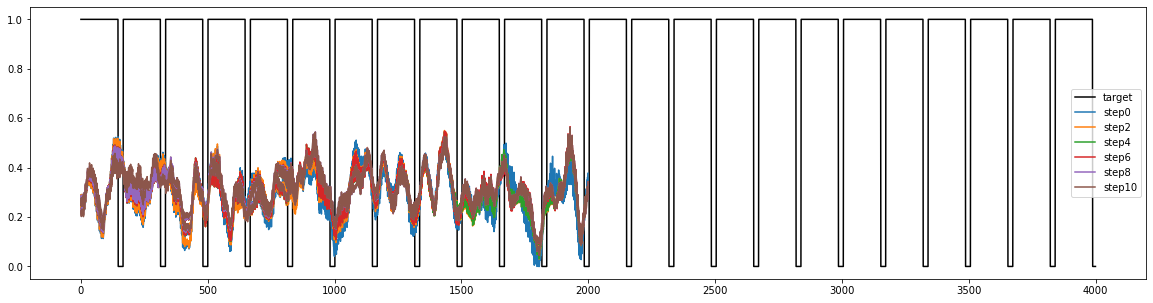

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w')
ax.plot(target, color='k', label='target')
for i, color in zip(range(0, 11, 2), colors):
    ax.plot(preds[0, i, :], label=f'step{i}', color=color)
    ax.plot(preds_rev[0, i, :], color=color)
ax.legend()

Testing predict functions

In [17]:
n = 10
l = 4000
freq_kmers = pd.read_csv('/home/alex/shared_folder/SCerevisiae/genome/W303/W303_3mer_freq.csv', index_col=[0, 1, 2])
np.random.seed(0)
seqs = utils.random_sequences(n, l, freq_kmers.iloc[:, 0], out='idx')
print(seqs.shape)
print(seqs)

(64, 3)
(10, 4000)
[[2 0 3 ... 0 1 0]
 [3 0 1 ... 1 3 0]
 [2 2 0 ... 3 3 2]
 ...
 [3 2 3 ... 0 3 3]
 [3 3 3 ... 1 1 2]
 [1 1 0 ... 2 3 3]]


In [37]:
to_predict = seqs#[:, ::100]
print(to_predict.shape)
preds = get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=None)
preds_rev = get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=None, reverse=True)
preds_flanks = []
preds_flanks_rev = []
for i in range(len(flank_left)):
    flanks=(flank_left[i], flank_right[i])
    preds_flanks.append(get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=flanks))
    preds_flanks_rev.append(get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=flanks, reverse=True))
preds_flanks = np.array(preds_flanks)
preds_flanks_rev = np.array(preds_flanks_rev)
print(preds.shape, preds_rev.shape)
print(preds_flanks.shape, preds_flanks_rev.shape)

(10, 4000)
(10, 2849) (10, 2849)
(16, 10, 4000) (16, 10, 4000)


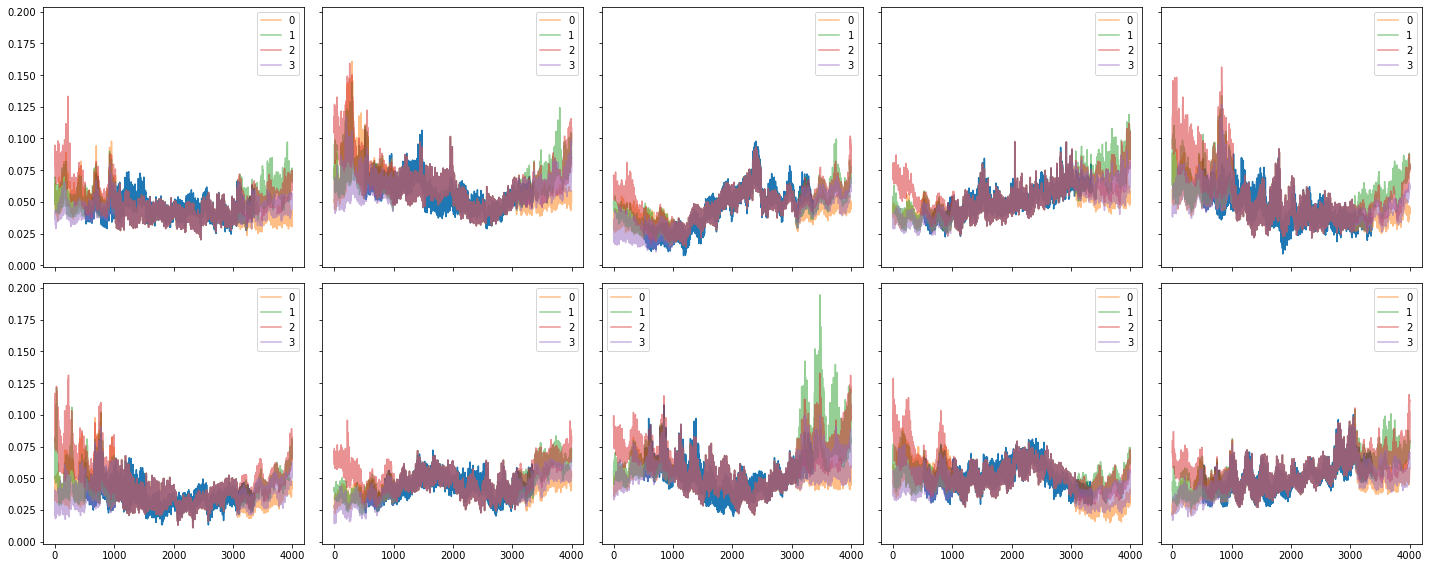

In [41]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8), facecolor='w', layout='tight', sharex=True, sharey=True)
start = 0
stop = 4
for i, ax in enumerate(axes.flatten()):
    ax.plot(np.arange(512, 512+preds.shape[-1]), preds[i])
    # ax.plot(np.arange(512+127, 512+127+preds.shape[-1]), preds_rev[i])
    ax.plot(preds_flanks[start:stop, i].T, label=[i for i in range(start, stop)], alpha=0.5)
    # ax.plot(preds_flanks_rev[start:stop, i].T, alpha=0.5)
    ax.legend()

In [21]:
to_predict = seqs[:, ::100]#.reshape(5, 2, -1)#
print(to_predict.shape)
preds_pol, indices_pol = tf_utils.get_profile(to_predict, model_pol, 2048, 128, middle=True, return_index=True)
preds_pol_rev, indices_pol_rev = tf_utils.get_profile(to_predict, model_pol, 2048, 128, reverse=True, middle=True, return_index=True)
preds_nuc, indices_nuc = tf_utils.get_profile(to_predict, model_nuc, 2001, return_index=True)
preds_nuc_rev, indices_nuc_rev = tf_utils.get_profile(to_predict, model_nuc, 2001, reverse=True, return_index=True)
preds_rna, indices_rna = tf_utils.get_profile(to_predict, model_rna, 2001, one_hot_converter=lambda x: utils.np_idx_to_one_hot(x, order='ATGC', extradims=-1), return_index=True)
preds_rna_rev, indices_rna_rev = tf_utils.get_profile(to_predict, model_rna, 2001, reverse=True, one_hot_converter=lambda x: utils.np_idx_to_one_hot(x, order='ATGC', extradims=-1), return_index=True)

(2, 6, 4000)


(0.0, 4000.0)

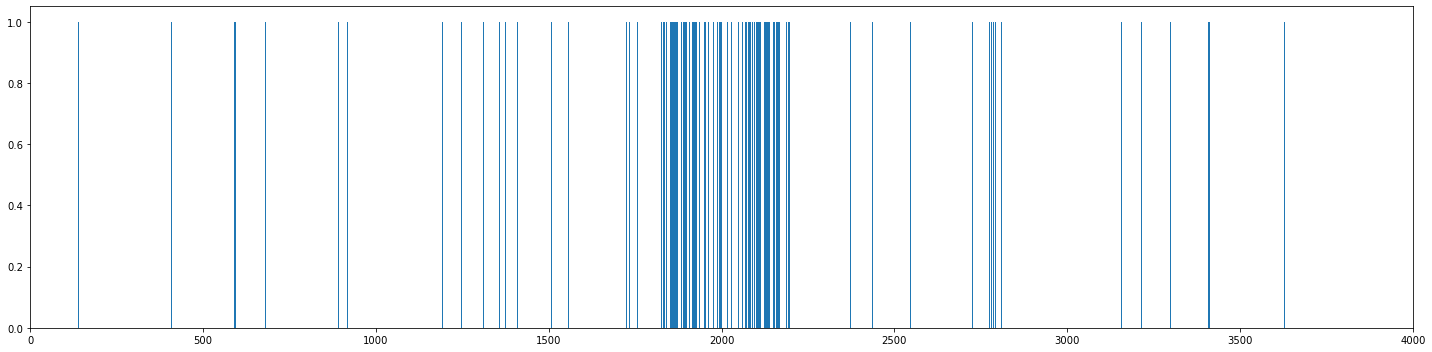

In [37]:
seq_idx = 1
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')
ax.bar(np.where(seqs[seq_idx, 0] != seqs[seq_idx, -1])[0], height=1)
ax.set_xlim(0, seqs.shape[-1])

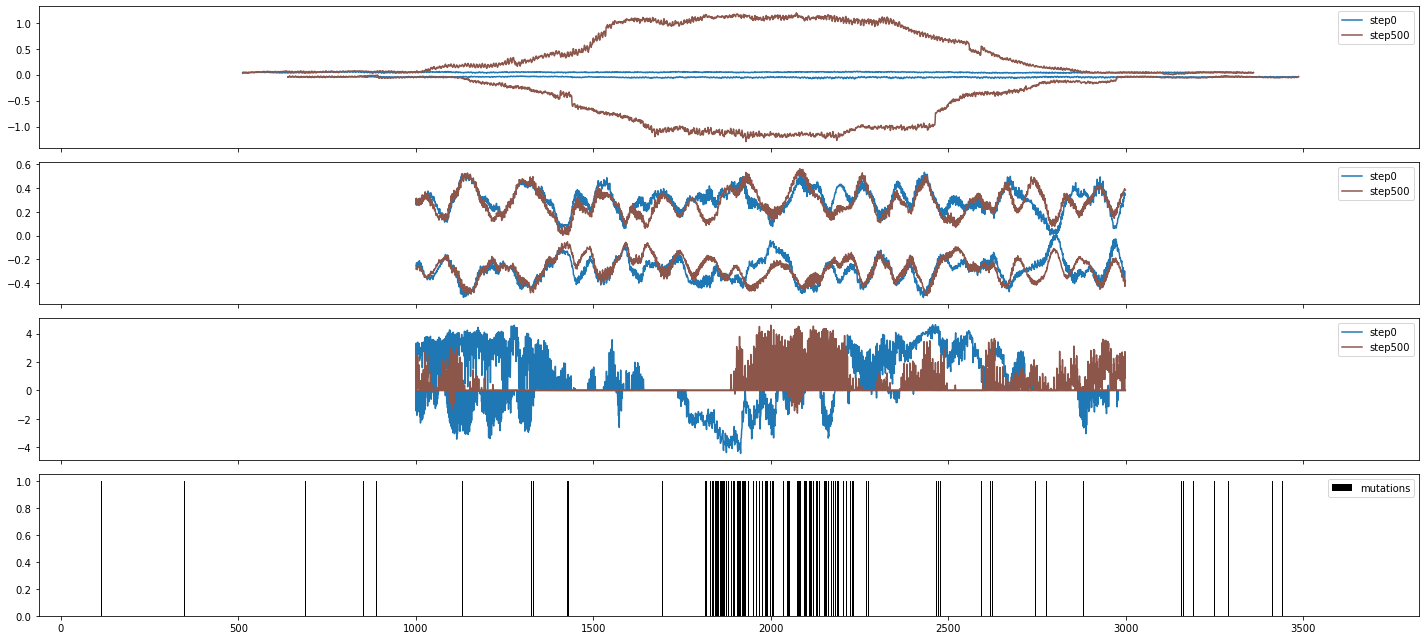

In [41]:
length = to_predict.shape[-1]
seq_idx = 0
fig, axes = plt.subplots(4, 1, figsize=(20, 9), facecolor='w', layout='tight', sharex=True)
for i in range(0, 6, 5):
    step = i*100
    color = colors[i]
    axes[0].plot(indices_pol, preds_pol[seq_idx, i, :], color=color, label=f'step{step}')
    axes[0].plot(indices_pol_rev, -preds_pol_rev[seq_idx, i, :], color=color)
    axes[1].plot(indices_nuc, preds_nuc[seq_idx, i, :], color=color, label=f'step{step}')
    axes[1].plot(indices_nuc_rev, -preds_nuc_rev[seq_idx, i, :], color=color)
    axes[2].plot(indices_rna, preds_rna[seq_idx, i, :], color=color, label=f'step{step}')
    axes[2].plot(indices_rna_rev, -preds_rna_rev[seq_idx, i, :], color=color)
axes[3].bar(np.where(seqs[seq_idx, 0] != seqs[seq_idx, step])[0], height=1, color='k', label='mutations')
for ax in axes:
    ax.legend()

# Saliency

In [4]:
def get_gradients(model, one_hots, batch_size=1024, predict=False, head_start=0, n_heads=1):
    grads = np.empty(one_hots.shape, dtype='float32')
    n_batches = int(np.ceil((len(one_hots) / batch_size)))
    preds = None
    for i in range(n_batches):
        batch_start, batch_stop = i*batch_size, (i+1)*batch_size
        X = tf.Variable(one_hots[batch_start:batch_stop], dtype=tf.float32)
        with tf.GradientTape() as tape:
            Y = model(X, training=False)[:, head_start:head_start+n_heads]
        grads[batch_start:batch_stop] = np.array(tape.gradient(Y, X))
        if predict:
            Y = np.array(Y).squeeze()
            if i == 0:
                preds = np.empty((len(one_hots),) + Y.shape[1:],
                                 dtype='float32')
            preds[batch_start:batch_stop] = Y
    if predict:
        return grads.squeeze(), preds
    else:
        return grads.squeeze()

In [22]:
with np.load('/home/alex/shared_folder/SCerevisiae/results/model_myco_pol_17/preds_mid_on_W303_Mmmyco.npz') as f:
    preds_pol = {k: f[k] for k in f.keys() if k[:3] == 'chr'}

In [20]:
with np.load('/home/alex/shared_folder/SCerevisiae/data/GSE217022/labels_myco_pol_ratio.npz') as f:
    labels_pol = {k: f[k] for k in f.keys() if k[:3] == 'chr'}

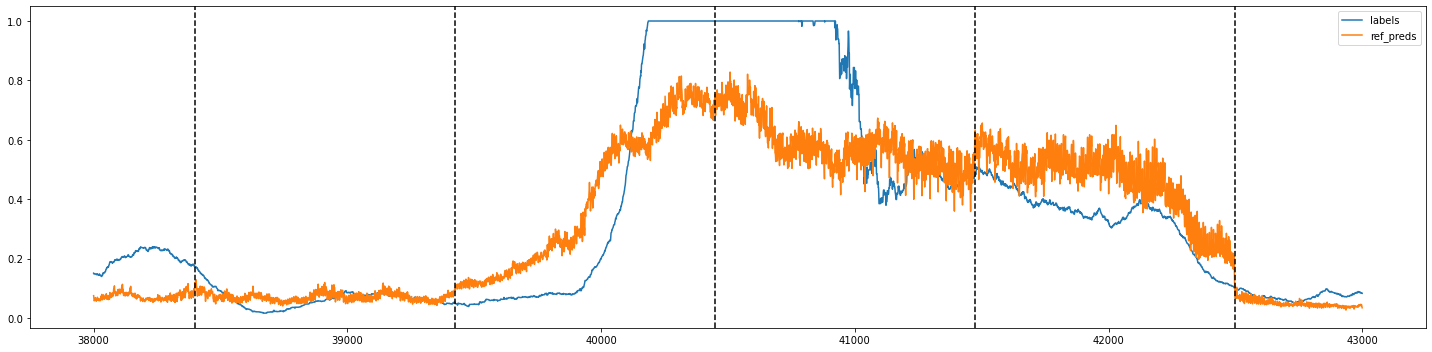

In [27]:
chr_id = 'chrIV' # 'chrIV'
start = 38000 # 38912
stop = 43000 # 40960
midlen = 128*8
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')
ax.plot(np.arange(start, stop), labels_pol[chr_id][start:stop], label='labels')
ax.plot(np.arange(start, stop), preds_pol[chr_id][start:stop], label='ref_preds')
sep = start + midlen - (start - midlen//2) % midlen
while sep < stop:
    ax.axvline(sep, color='k', linestyle='--')
    sep += midlen
ax.legend()

In [47]:
winsize = 2048
head_interval = 128
offset = 0
one_hots = utils.strided_sliding_window_view(
    one_hot_yeast[chr_id][start+offset:stop+offset+head_interval-1],
    (winsize, 4),
    winsize//2,
    head_interval).reshape(-1, winsize, 4)
one_hots.shape

(128, 2048, 4)

In [57]:
winsize = 2048
head_start = 8
offset = -128*8
one_hots = utils.sliding_window_view(
    one_hot_yeast[chr_id][start+offset:stop+offset+winsize-1],
    (winsize, 4)).reshape(-1, winsize, 4)
one_hots.shape

(2048, 2048, 4)

In [58]:
grads, preds = get_gradients(model_pol, one_hots, predict=True, head_start=8, n_heads=1)
preds_t = preds.T.ravel()
print(preds.shape)

(2048,)


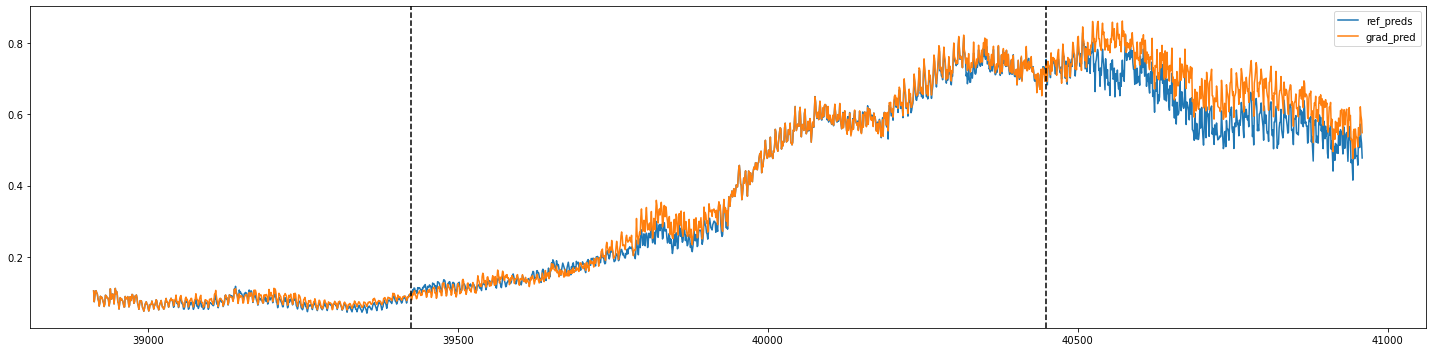

In [60]:
chr_id = 'chrIV'
start = 38912
stop = 40960
midlen = 128*8
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')
ax.plot(np.arange(start, stop), preds_pol[chr_id][start:stop], label='ref_preds')
# ax.plot(np.arange(start + midlen//2, stop - midlen//2), preds_t, label='grad_pred')
ax.plot(np.arange(start, stop), preds_t, label='grad_pred')
sep = start + midlen - (start - midlen//2) % midlen
while sep < stop:
    ax.axvline(sep, color='k', linestyle='--')
    sep += midlen
ax.legend()

In [61]:
print(grads.shape)
grads_proj = grads - grads.mean(axis=-1, keepdims=True)
print(grads_proj.shape)
grads_seq = grads[one_hots].reshape(grads.shape[:-1])
print(grads_seq.shape)
grads_proj_seq = grads_proj[one_hots].reshape(grads.shape[:-1])
print(grads_proj_seq.shape)

(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048)
(2048, 2048)


<AxesSubplot:>

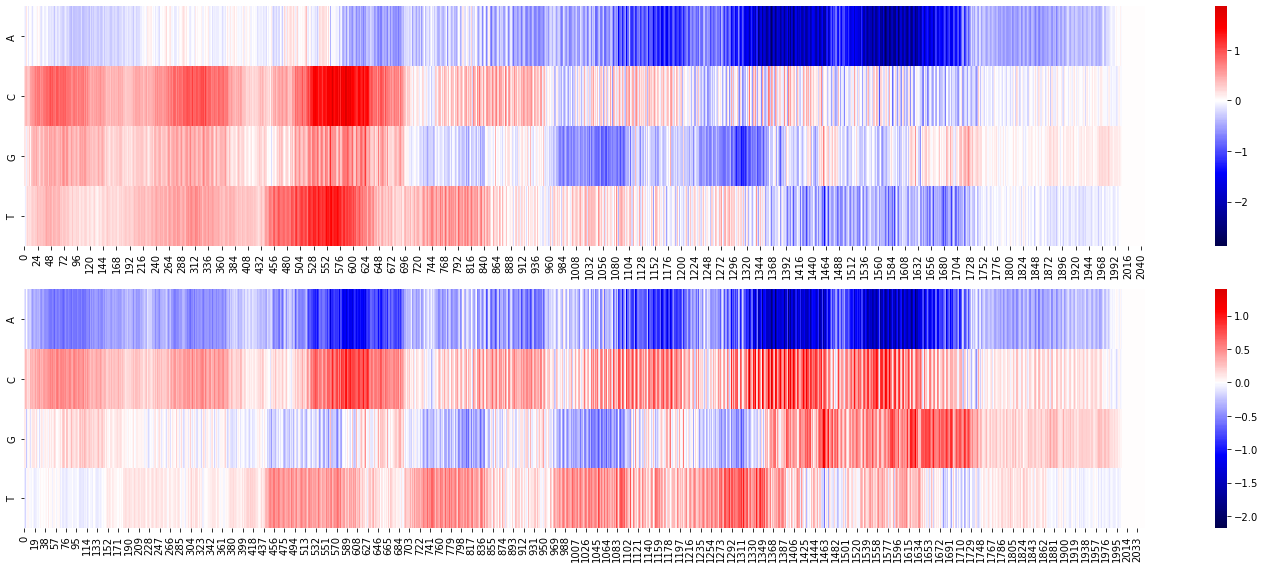

In [62]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), facecolor='w', layout='tight')
# sns.heatmap(grads_proj[0].T, ax=ax, cmap='seismic', center=0)
vmin = None # -2
sns.heatmap(grads.sum(axis=0).T, cmap='seismic', center=0, vmin=vmin, ax=axes[0],# cbar_ax=axes[0, 1],
            yticklabels=list('ACGT'))
sns.heatmap(grads_proj.sum(axis=0).T, cmap='seismic', center=0, vmin=vmin, ax=axes[1],# cbar_ax=axes[0, 1],
            yticklabels=list('ACGT'))

In [64]:
n_seqs = 2048
winsize = 2048
aligned_grads_seq = np.zeros((n_seqs, winsize+n_seqs), dtype='float32')
for j in range(n_seqs):
    aligned_grads_seq[j, j:j+winsize] = grads_seq[j]
print(aligned_grads_seq.shape)
aligned_grads_proj_seq = np.zeros((n_seqs, winsize+n_seqs), dtype='float32')
for j in range(n_seqs):
    aligned_grads_proj_seq[j, j:j+winsize] = grads_proj_seq[j]
print(aligned_grads_proj_seq.shape)

(2048, 4096)
(2048, 4096)


<AxesSubplot:>

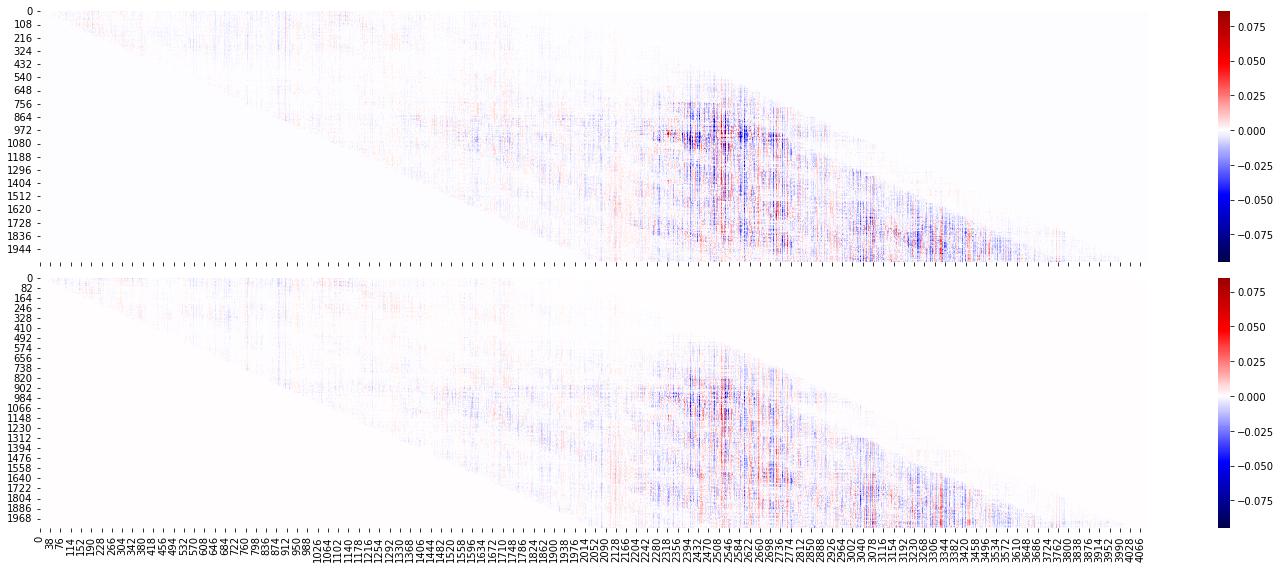

In [65]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), facecolor='w', layout='tight', sharex=True)
vmin = None # -2
sns.heatmap(aligned_grads_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[0])
sns.heatmap(aligned_grads_proj_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[1])

<AxesSubplot:>

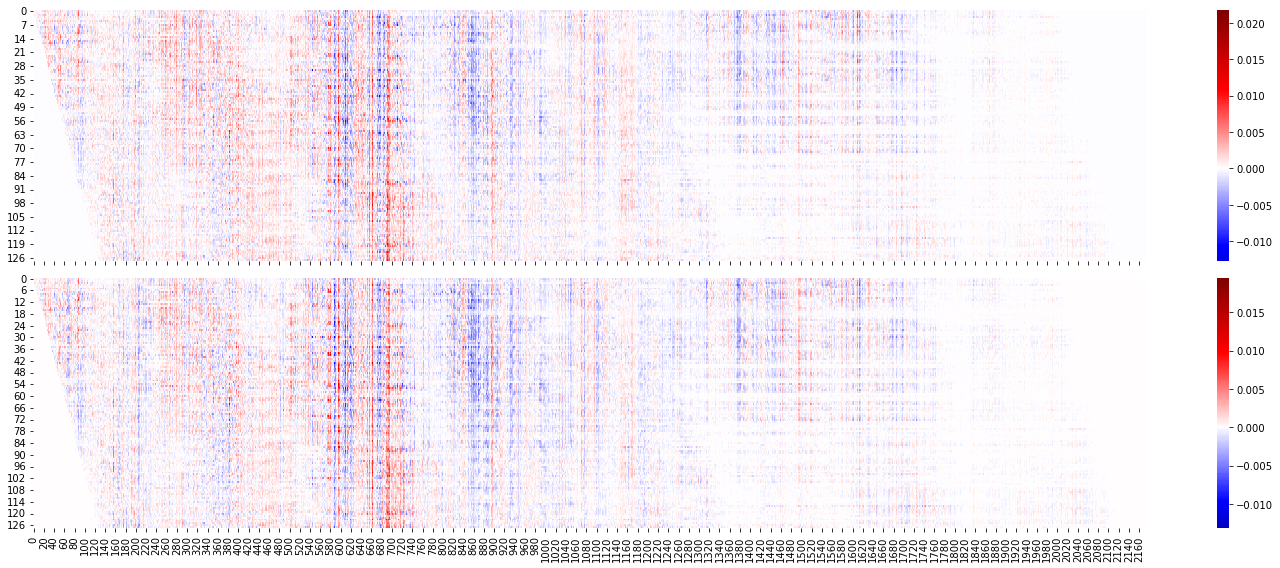

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), facecolor='w', layout='tight', sharex=True)
vmin = None # -2
sns.heatmap(aligned_grads_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[0])
sns.heatmap(aligned_grads_proj_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[1])

<AxesSubplot:>

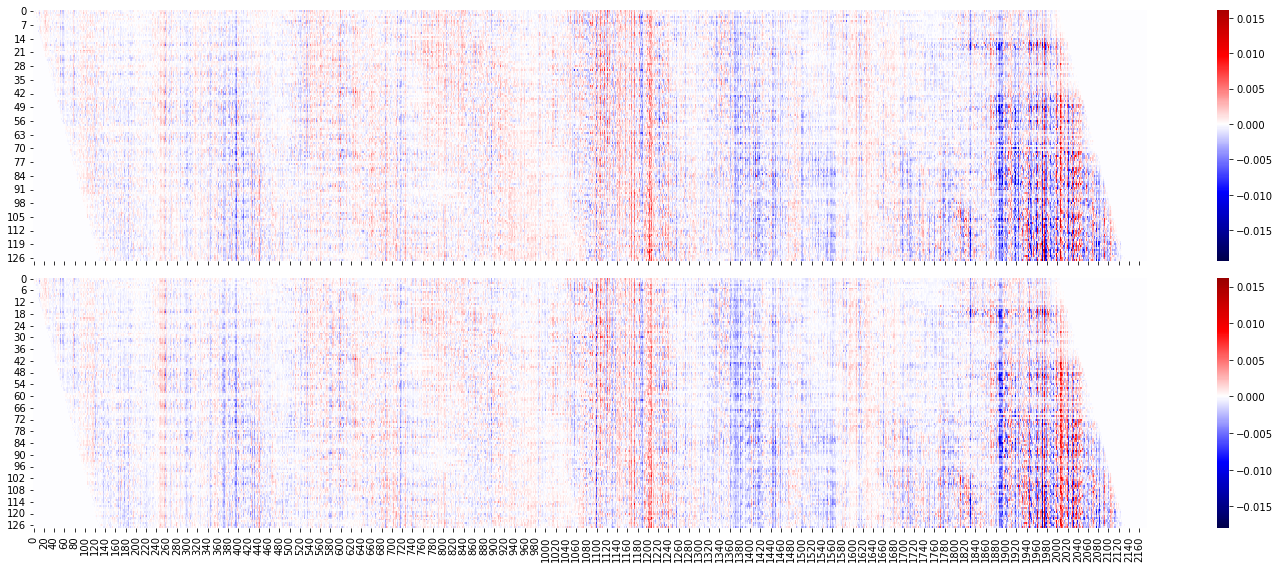

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), facecolor='w', layout='tight', sharex=True)
vmin = None # -2
sns.heatmap(aligned_grads_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[0])
sns.heatmap(aligned_grads_proj_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[1])

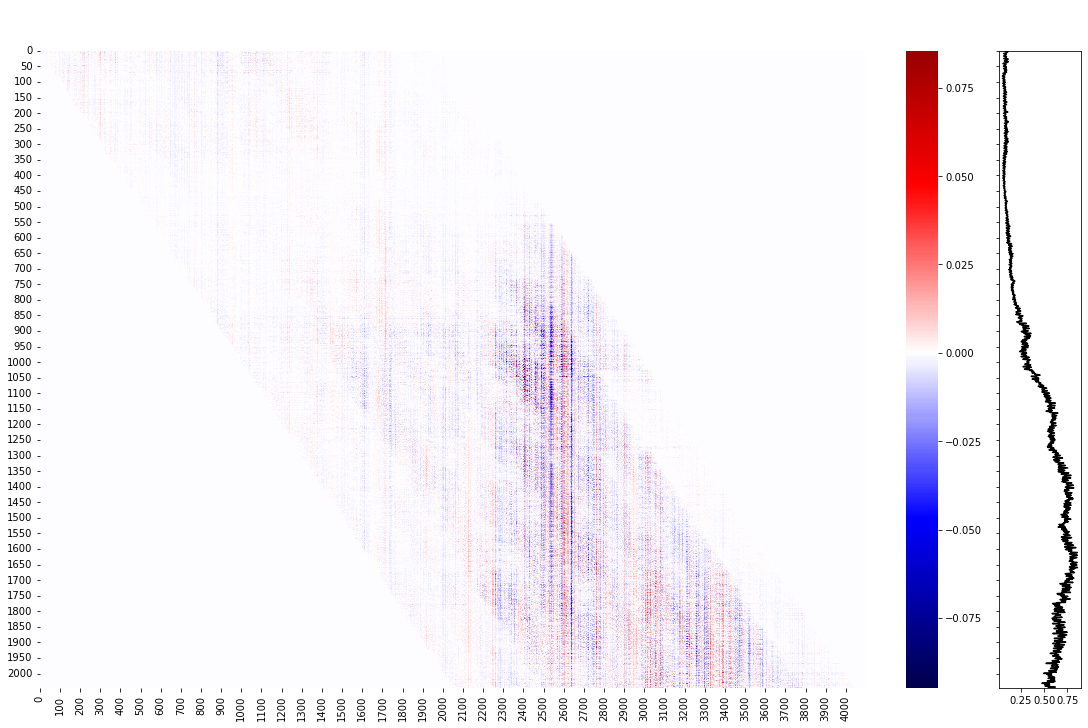

In [69]:
plot_start = 0
plot_stop = 4096
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey='row', sharex='col', layout='constrained',
                         gridspec_kw={'width_ratios': [10, 1],
                                      'height_ratios': [1, 20]})
fig.set_facecolor('w')
# lm.Logo(pd.DataFrame(one_hot_yeast['chrIV'][start+plot_start:start+plot_stop], columns=list('ACGT')), ax=axes[0, 0])
axes[0, 0].set_axis_off()
axes[0, 1].remove()
sns.heatmap(aligned_grads_seq[:, plot_start:plot_stop], cmap='seismic', center=0, ax=axes[1, 0],
            xticklabels=100, yticklabels=50)
axes[1, 1].plot(preds, np.arange(len(preds)), color='k', label='predictions')
plt.show()
plt.close()